# Домашнее задание 8

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 21 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_8

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import cm
import pandas as pd
import random
import sys
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.datasets import load_svmlight_file
import time 
from tqdm import trange
from tqdm import tqdm
np.random.seed(4)

## Задача 1

Рассмотрим билинейную седловую задачу:
\begin{equation}
\min_{x \in [-10; 10]^d} \max_{y \in [-10; 10]^d} f(x,y) = (x-b_x)^T A (y - b_y) + \frac{\lambda}{2}\| x - b_x\|^2 - \frac{\lambda}{2}\| y - b_y\|^2,
\end{equation}
где в качестве матрицы $A$ - случайно сгенерированная матрица с $L =1000$, $\mu = 0.01$, $d = 100$, $b_x$ и $b_y$ - случайные векторы c компонентами из отрезка $[-10; 10]$, $\lambda = 1$.

__(а)__ Какое решение у данной задачи? Является ли данная задача сильно выпуклой по $x$ и сильно вогнутой по $y$? Если да, то чему равна константа сильной выпуклости? Является ли оператор, соотвествующего это задаче вариационного неравенства, сильно монотонным? Липшицевым? Чему равны $L$ и $\mu$ для данного оператора? 

Покажем сильную выпуклость: 
$$ \nabla_x f(x, y) = A(y - b_y) + \lambda (x - b_x)$$ 

$$ \nabla_y f(x, y) = A^T(x - b_x) - \lambda (y - b_y)$$

$$ \nabla_x^2 f(x, y) = \lambda \cdot I $$

$$ \nabla_y^2 f(x, y) = -\lambda \cdot I $$
Тогда из опредления сильной выпуклости: $\mu_x = \mu_y = \lambda$. Т.е. задача является сильно выпуклой по $x$ и сильно вогнутой по $y$.

Найдем решение, имеем: 
$$\nabla_x f(x, y) = 0 $$
$$\nabla_y f(x, y) = 0 $$
Тогда $x = b_x, y = b_y$. Они из допустимого множества $\Rightarrow$ это решение.

Исследуем оператор вариационного неравентва, имеем следующее: 
$$z := \left(\begin{array}{cc}
              x \\
              y \end{array}\right)
~\text{ и }~ 
F(z) := \left(\begin{array}{cc}
              \nabla_x f(x, y) \\
              -\nabla_y f(x, y) \end{array}\right)$$
Из этого следует, что: $$\left<F(z_1) - F(z_2), z_1 - z_2 \right> = \left<\nabla_x f(x_1, y_1) - \nabla_x f(x_2, y_2), x_1 - x_2 \right> - \left<\nabla_y f(x_1, y_1) - \nabla_y f(x_2, y_1), y_1 - y_2 \right> =\\=  \left<A(y_1 - y_2), x_1 - x_2\right> + \lambda \cdot \|x_1 - x_2\|_2^2 - \left<A^T(x_1 - x_2), y_1 - y_2\right> + \lambda \cdot \|y_1 - y_2\|_2^2 =\\= \lambda \cdot \left(\|x_1 - x_2\|_2^2 + \|y_1 - y_2\|_2^2\right) = \lambda \cdot \|z_1 - z_2\|_2^2$$
Тогда по опредлению сильной монотонности: $\mu = \lambda$.

Теперь рассмотрим липшицевость, заметим, что верно следующее нервенство:
$$\left\|\left(\begin{array}{cc}
              x \\
              y \end{array}\right)\right\|_2 \leq \|x\|_2 + \|y\|_2$$
Тогда распишем: $$\|F(z_1) - F(z_2) \|_2 \leq \|\nabla_x f(x_1, y_1) - \nabla_x f(x_2, y_2)\|_2 + \|\nabla_y f(x_1, y_1) - \nabla_y f(x_2, y_2)\|_2 = \\ = \|A(y_1 - y_2) + \lambda \cdot (x_1 - x_2)\|_2 + \|A^T(x_1 - x_2) + \lambda \cdot (y_1 - y_2)\|_2 \leq \\ \leq \|A\|_2 \cdot \|y_1 - y_2\|_2 + \lambda \|x_1 - x_2\|_2 + \|A^T\|_2 \cdot \|x_1 - x_2\|_2 + \lambda \|y_1 - y_2\|_2 = \\ = (\|A\|_2 + \lambda) \cdot (\|x_1 - x_2\|_2 + \|y_1 - y_2\|_2) \leq \\ \leq 2 (\|A\|_2 + \lambda) \cdot \|z_1 - z_2\|_2 $$
То есть можно взять $L = 2\cdot (\lambda_{max}\left(A\right) + \lambda)$

Итого оператор и сильно монотонный, и липшицев.

__(б)__ Решите данную задачу с помощью метода градиентного спуска(подъема) с проекцией и с помощью метода Экстраградиента с проекцией(смотри Секцию 3.3 [статью](https://arxiv.org/pdf/1802.10551.pdf)). Для начала попробуйте теоретические шаги для данных методов. Далее подберите шаг для наилучшей сходимости. Постройте график сходимости (относительное расстояние до решения по аргументу от числа подсчетов градиентов). На графике должно быть 4 линии, по две на каждый из методов. Сделайте вывод.

Вспомогательные функции и костанты:

In [3]:
def generator(d, mu, L):
    D = np.diag(np.repeat([L, mu], [d / 2 + 1, d / 2 - 1]))
    Sample = (L - mu) * np.random.rand(d, d) + mu
    Q, _ = np.linalg.qr(Sample)
    A = Q.T @ D @ Q
    return A

In [4]:
d = 100
mu = 0.01
L = 1000
n = 10
lam = 1
A = generator(d, mu, L)
b_x = 20 * np.random.random_sample(d) - 10
b_y = 20 * np.random.random_sample(d) - 10

In [5]:
def f(x, y):
    return (x - b_x).T @ A @ (y - b_y) + lam / 2  * (np.linalg.norm(x - b_x, ord = 2)^2 - np.linalg.norm((y - b_y), ord = 2)^2)

def nabla_f_x(x, y):
    return A @ (y - b_y) + lam * (x - b_x)

def nabla_f_y(x, y):
    return (x - b_x).T @ A - lam * (y - b_y)

def proj_on_cube(x):
    x[x > 10] = 10
    x[x < -10] = -10
    
    return x

def diff_exact(w1, solution):
    return np.linalg.norm(w1 - solution, ord = 2)

def gamma_bilinear(c):
    return c * mu / L**2

Реализуем градиентный спуск и подберем лучший шаг:

In [6]:
 def BilinearGD(grad_f_x, grad_f_y, kriteria, proj, gamma, c, max_iter = 10**5, eps = 10**(-1)):
    x_cur = 20 * np.random.randn(d)
    y_cur = 20 * np.random.randn(d)
    error = []
    coeff = kriteria(np.concatenate((x_cur, y_cur)), np.concatenate((b_x, b_y)))
    
    for i in trange(max_iter, file=sys.stdout, ncols = 80, colour = 'cyan'):
        x_new = proj(x_cur - gamma(c) * grad_f_x(x_cur, y_cur))
        y_new = proj(y_cur + gamma(c) * grad_f_y(x_cur, y_cur))
        
        error.append(kriteria(np.concatenate((x_new, y_new)), np.concatenate((b_x, b_y))) / coeff)
        if error[-1] < eps:
            break
        
        x_cur = x_new
        y_cur = y_new
        
    return np.concatenate((x_new, y_new)), error

100%|████████████████████████████████| 100000/100000 [00:06<00:00, 14896.42it/s]


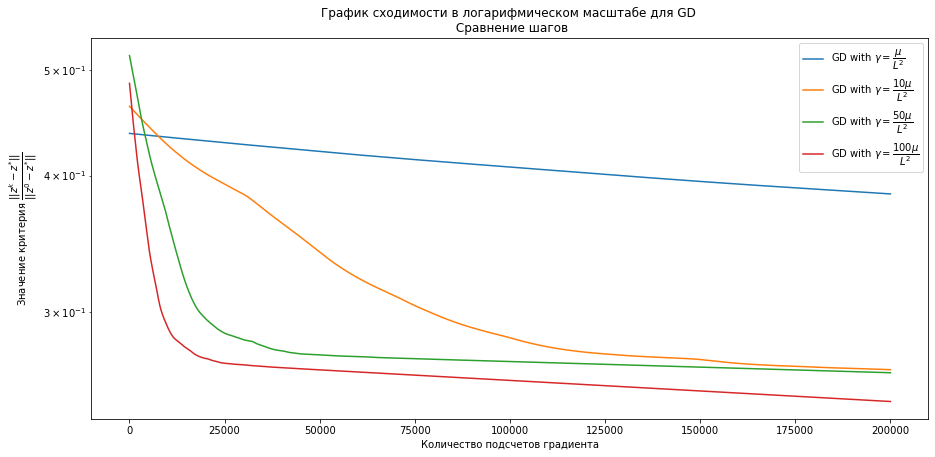

In [7]:
fig = plt.figure(figsize = (15, 7))
iter_grad_calls = 2
for c in [1, 10, 50, 100]:
    ans, error = BilinearGD(nabla_f_x, nabla_f_y, diff_exact, proj_on_cube, gamma_bilinear, c)
    x = np.array(range(len(error))) * iter_grad_calls 
    if c == 1:
        plt.plot(x, error, label = 'GD' + r' with $\gamma = \dfrac{\mu}{L^2}$')
        continue
    plt.plot(x, error, label = 'GD' + r' with $\gamma = \dfrac{%i \mu}{L^2}$' %c)
    
plt.title("График сходимости в логарифмическом масштабе для GD \n Сравнение шагов")
plt.xlabel("Количество подсчетов градиента")
plt.ylabel(r"Значение критерия $\dfrac{||z^k - z^{*}||}{||z^0 - z^{*}||}$")
plt.yscale("log")
plt.legend()
plt.show()

Лучший шаг получился с $c = 100$. 

Теперь реализуем метод экстраградиента и подберем наилучший шаг:

In [8]:
def ExtraGD(grad_f_x, grad_f_y, kriteria, proj, gamma, c, max_iter = 10**5, eps = 10**(-3)):
    x_cur = 20 * np.random.randn(d)
    y_cur = 20 * np.random.randn(d)
    error = []
    coeff = kriteria(np.concatenate((x_cur, y_cur)), np.concatenate((b_x, b_y)))
    
    for i in trange(max_iter, file = sys.stdout, ncols = 80, colour = 'cyan'):
        x_crutch = proj(x_cur - gamma(c) * grad_f_x(x_cur, y_cur))
        y_crutch = proj(y_cur + gamma(c) * grad_f_y(x_cur, y_cur))
        
        x_new = proj(x_cur - gamma(c) * grad_f_x(x_crutch, y_crutch))
        y_new = proj(y_cur + gamma(c) * grad_f_y(x_crutch, y_crutch))
        
        error.append(kriteria(np.concatenate((x_new, y_new)), np.concatenate((b_x, b_y))) / coeff)
        if error[-1] < eps:
            break
        
        x_cur = x_new
        y_cur = y_new
        
    return np.concatenate((x_new, y_new)), error

100%|████████████████████████████████| 100000/100000 [00:07<00:00, 12523.16it/s]


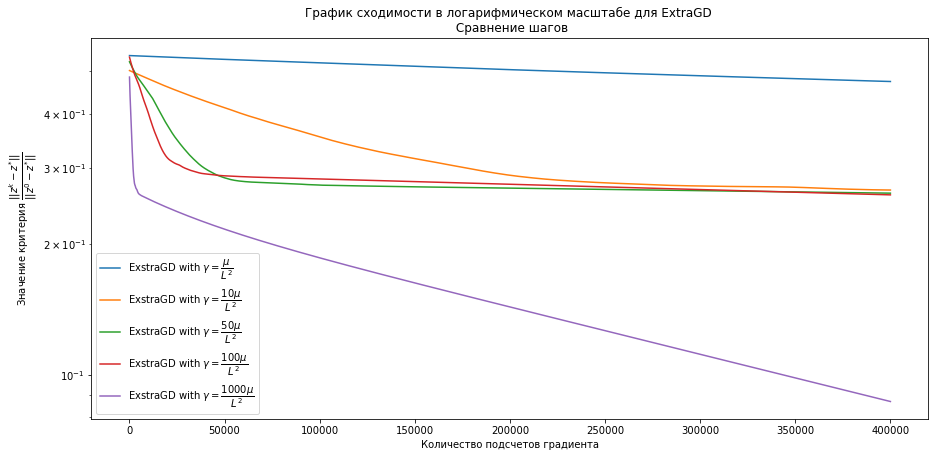

In [9]:
fig = plt.figure(figsize = (15, 7))
iter_grad_calls = 4
for c in [1, 10, 50, 100, 1000]:
    ans, error = ExtraGD(nabla_f_x, nabla_f_y, diff_exact, proj_on_cube, gamma_bilinear, c)
    x = np.array(range(len(error))) * iter_grad_calls 
    if c == 1:
        plt.plot(x, error, label = 'ExstraGD' + r' with $\gamma = \dfrac{\mu}{L^2}$')
        continue
    plt.plot(x, error, label = 'ExstraGD' + r' with $\gamma = \dfrac{%i \mu}{L^2}$' %c)
    
plt.title("График сходимости в логарифмическом масштабе для ExtraGD \n Сравнение шагов")
plt.xlabel("Количество подсчетов градиента")
plt.ylabel(r"Значение критерия $\dfrac{||z^k - z^{*}||}{||z^0 - z^{*}||}$")
plt.yscale("log")
plt.legend()
plt.show()

Лучший шаг при $c = 1000$.

Итого имеем:

100%|████████████████████████████████| 200000/200000 [00:08<00:00, 24195.23it/s]


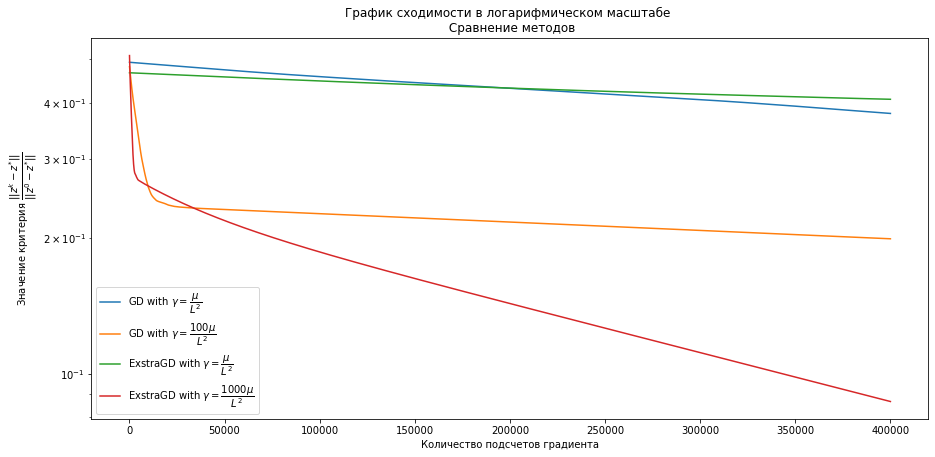

In [10]:
fig = plt.figure(figsize = (15, 7))
iter_grad_calls_extra = 4
iter_grad_calls_GD = 2
_, error_extra_1 = ExtraGD(nabla_f_x, nabla_f_y, diff_exact, proj_on_cube, gamma_bilinear, 1)
_, error_extra_1000 = ExtraGD(nabla_f_x, nabla_f_y, diff_exact, proj_on_cube, gamma_bilinear, 1000)
_, error_GD_1 = BilinearGD(nabla_f_x, nabla_f_y, diff_exact, proj_on_cube, gamma_bilinear, 1, max_iter = 2 * 10**5)
_, error_GD_100 = BilinearGD(nabla_f_x, nabla_f_y, diff_exact, proj_on_cube, gamma_bilinear, 100, max_iter = 2 * 10**5)
x1 = np.array(range(len(error_extra_1))) * iter_grad_calls_extra
x2 = np.array(range(len(error_GD_1))) * iter_grad_calls_GD
plt.plot(x2, error_GD_1, label = 'GD' + r' with $\gamma = \dfrac{\mu}{L^2}$')
plt.plot(x2, error_GD_100, label = 'GD' + r' with $\gamma = \dfrac{100\mu}{L^2}$')
plt.plot(x1, error_extra_1, label = 'ExstraGD' + r' with $\gamma = \dfrac{\mu}{L^2}$')
plt.plot(x1, error_extra_1000, label = 'ExstraGD' + r' with $\gamma = \dfrac{1000\mu}{L^2}$')
    
plt.title("График сходимости в логарифмическом масштабе \n Сравнение методов")
plt.xlabel("Количество подсчетов градиента")
plt.ylabel(r"Значение критерия $\dfrac{||z^k - z^{*}||}{||z^0 - z^{*}||}$")
plt.yscale("log")
plt.legend()
plt.show()

Как видно из графиков, экстраградиент действительно значительно улучшает скорость сходимости, однако необходимо правильно подобрать шаг.

## Задача 2

Теперь рассмотрим билинейную задачу на симплексе. Описание задачи возьмите из [лекций](https://www2.isye.gatech.edu/~nemirovs/BrazilTransparenciesJuly4.pdf) - Слайд 125 "How it Works: Policeman vs. Burglar" и следующий.

__(а)__ Сгенерируйте матрицу для данной задачи размера $n=10$ c $\theta = 1$.

Нумерацию домов будем вести от нуля, т.е. имеем $i, j\in \overline{0, n^2 - 1}$, тогда дом с номером $i$ имеет координаты $(i\;\text{div}\;n, i\;\text{mod}\;n)$, тогда возьмем $dist(i, j) \overset{\mathrm{def}}{=} ||(i\;\text{div}\;n - j\;\text{div}\;n,\; i\;\text{mod}\;n - j\;\text{mod}\;n)||$. В определении матрицы будем пользоваться евклидовой нормой, при инициализации весов - бесконечной. $%, либо можно для получения такой же пирамиды, как в источнике, взять$

Получаем следующую постановку задачи: 
$$\min_{x \in \Delta_d} \max_{y \in \Delta_d} f(x,y) := y^T A x,$$
здесь $d = n^2$.
$\\$
Поскольку $f(x,y) = y^T A x$ есть функция из задачи 1 с $b_x = b_y = \bar{0}, \lambda = 0$, то сразу получаем оценки на константы липшица и сильной выпуклости: 
$$ \mu = 0, \quad L = 2 \cdot \lambda_{max}(A).$$

Блок вспомогательных функций:

In [11]:
def nabla_f_x(x, y):
    return A.T @ y

def nabla_f_y(x, y):
    return A @ x

In [12]:
def dist_func(a, b, norm = 2):
    h_1 = np.array([a // n, a % n])
    h_2 = np.array([b // n, b % n])
    return np.linalg.norm(h_2 - h_1, ord = norm)

In [13]:
def generate_houses(d, theta, dist_func, weights = None):
    result = np.zeros((d, d))
    if weights is None:
        weights = np.random.random_sample(d)
    for i in range(d):
        for j in range(d) :
            result[i][j] = weights[i] * (1 - np.exp(-theta * dist_func(i, j)))
    return result

In [14]:
def prox_simplex(z, ksi):
    prox = np.zeros(len(z))
    crutch = 0
    
    for z_i, ksi_i in zip(z, ksi):
        crutch += z_i * np.exp(-ksi_i)
        
    for j, (z_j, ksi_j) in enumerate(zip(z, ksi)):
        prox[j] = (1 / crutch) * z_j * np.exp(-ksi_j)
    
    return prox

In [15]:
def diff_min_max(x, y):
    return max(A @ x) - min(A.T @ y)

In [16]:
def gamma_SMP(c):
    return c / np.sqrt(3) / L

Матрица и константы:

In [17]:
d = 100
n = 10
theta = 1
A = generate_houses(d, theta, dist_func, weights = np.array([1 / (dist_func(i, (n // 2) * (n + 1), norm = np.inf) + 20) for i in range(100)]))
mu = 0
L = 2 * max(np.linalg.eigvals(A).real)
print('L = ', L)
print(r'mu = ', mu)

L =  8.1455853658456
mu =  0


Здесь в качетсве весов взято распределение из условий задачи в презентации, записать его можно так:
$$w_i = \frac{1}{dist(i, j_{center}) + 2n}$$
где в $dist$ используется бесконечная норма, а $j_{center}$ обозначает координату центрального дома.

Далее я рассмотрю два варианта: веса такого вида и случайные веса из равномерного распределения на [0,1).

__(б)__ Для данной задачи предложите модификацию метода Экстраградиента, которая учитывает, что задача решается на симплексе. В этом может помочь [статья](https://arxiv.org/pdf/0809.0815.pdf) (смотри Секцию 3.3). Реализуйте данный метод.

Критерий сходимости из статьи:
$$\text{Err}_{\text{vi}}(z) = \max_{u \in Z} \left\langle F(u), z - u \right\rangle $$
Немного подумав(решив ККТ) можно получить, что в нашем случае: 
$$\text{Err}_{\text{vi}}(z) = \max_{i \in \overline{1, d}}\{(Ax)_i\} - \min_{i \in \overline{1, d}}\{(A^Ty)_i\} $$
Реализуем SMP:

In [18]:
def SMP(grad_f_x, grad_f_y, prox, gamma, c, max_iter = 4 * 10**3, eps = 10**(-8)):
    x_cur = np.random.random_sample(d)
    x_cur = x_cur / np.linalg.norm(x_cur, ord = 1)
    y_cur = np.random.random_sample(d)
    y_cur = y_cur / np.linalg.norm(y_cur, ord = 1)
    r_x_cur = x_cur
    r_y_cur = y_cur
    w_x_history = []
    w_y_history = []
    error = []
    
    for i in trange(max_iter, file = sys.stdout, ncols = 80, colour = 'cyan'):

        w_x_cur = prox(r_x_cur, gamma(c) * grad_f_x(r_x_cur, r_y_cur))
        w_y_cur = prox(r_y_cur, -gamma(c) * grad_f_y(r_x_cur, r_y_cur))
        r_x_new = prox(r_x_cur, gamma(c) * grad_f_x(w_x_cur, w_y_cur))
        r_y_new = prox(r_y_cur, -gamma(c) * grad_f_y(w_x_cur, w_y_cur))
        
        w_x_history.append(w_x_cur)
        w_y_history.append(w_y_cur)
        x_new = sum(w_x_history) / len(w_x_history)
        y_new = sum(w_y_history) / len(w_y_history)
        
        error.append(diff_min_max(x_new, y_new))
        if error[-1] < eps:
            break
            
        r_x_cur = r_x_new
        r_y_cur = r_y_new
        x_cur = x_new
        y_cur = y_new
        
    return np.concatenate((x_new, y_new)), error

100%|██████████████████████████████████████| 4000/4000 [00:14<00:00, 280.54it/s]


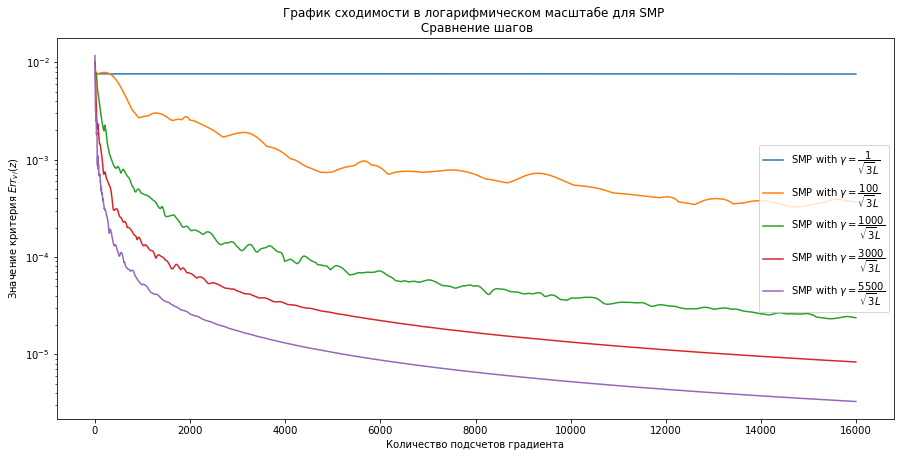

In [20]:
fig = plt.figure(figsize = (15, 7))
iter_grad_calls = 4
for c in [1, 100, 1000, 3000, 5500]:
    if c == 5500:
        ans, error = SMP(nabla_f_x, nabla_f_y, prox_simplex, gamma_SMP, c)
    else:
        _, error = SMP(nabla_f_x, nabla_f_y, prox_simplex, gamma_SMP, c)
    x = np.array(range(len(error))) * iter_grad_calls 
    if c == 1:
        plt.plot(x, error, label = 'SMP' + r' with $\gamma = \dfrac{1}{\sqrt{3}L}$')
        continue
    plt.plot(x, error, label = 'SMP' + r' with $\gamma = \dfrac{%i}{\sqrt{3}L}$' %c)
    
plt.title("График сходимости в логарифмическом масштабе для SMP \n Сравнение шагов")
plt.xlabel("Количество подсчетов градиента")
plt.ylabel(r"Значение критерия $Err_{vi}(z)$")
plt.yscale("log")
plt.legend()
plt.show()

Лучшим получился шаг $\gamma = \dfrac{5500}{\sqrt{3}L}$.

Теперь посмотрим, что получится, если инициализировать веса случайно:

In [21]:
w = np.random.random_sample(d)
A = generate_houses(d, theta, dist_func, weights = w)
L = 2 * max(np.linalg.eigvals(A).real)
print('L = ', L)
print(r'mu = ', mu)

L =  101.55453517081503
mu =  0


100%|██████████████████████████████████████| 4000/4000 [00:14<00:00, 281.00it/s]


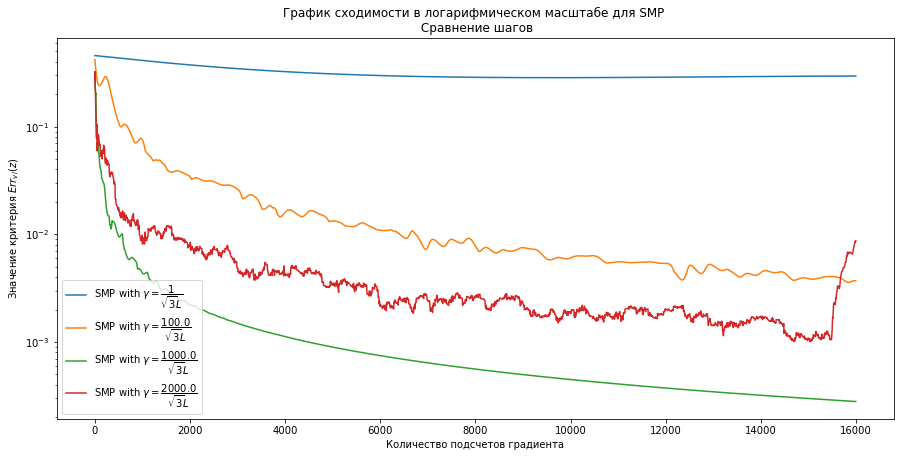

In [22]:
fig = plt.figure(figsize = (15, 7))
iter_grad_calls = 4
for c in [1, 100, 1000, 2000]:
    _, error = SMP(nabla_f_x, nabla_f_y, prox_simplex, gamma_SMP, c, max_iter = 4 * 10**3, eps = 10**(-6))
    x = np.array(range(len(error))) * iter_grad_calls 
    if c == 1:
        plt.plot(x, error, label = 'SMP' + r' with $\gamma = \dfrac{1}{\sqrt{3}L}$')
        continue
    plt.plot(x, error, label = 'SMP' + r' with $\gamma = \dfrac{%.1f}{\sqrt{3}L}$' %c)
    
plt.title("График сходимости в логарифмическом масштабе для SMP \n Сравнение шагов")
plt.xlabel("Количество подсчетов градиента")
plt.ylabel(r"Значение критерия $Err_{vi}(z)$")
plt.yscale("log")
plt.legend()
plt.show()

Как видно, для такой инициализации сходимость получилась помедленнее, но это и логично - более общий случай.

__(в)__ Решите билинейную задачу на симплексе с помощью нового метода и методов из Задачи 1. Как будете измерять сходимость? Возможно, в работах, из которых были взяты методы, найдется ответ. Постройте график сходимости. Визуализирйте полученный ответ, как это сделано в файле с лекциями. Сделайте вывод.  

Сходимость будем измерять по критерию из статьи(как в предыдущем пункте), так мы сможем корректно сравнить результаты.

In [23]:
def gamma_bilinear(c):
    return c / L**2

In [24]:
def proj_simplex(x):
    x_sort = sorted(x, reverse=True)
    rho = 0
    ind = x_sort[0]
    summ = x_sort[0]
    
    for i in range(1, len(x)):
        ind += x_sort[i]
        if x_sort[i] + 1 / (i + 1) * (1 - ind) > 0:
            rho = i
            summ = ind

    lam = 1 / (rho + 1) * (1 - summ)
    proj = np.zeros(len(x))

    for i in range(len(x)):
        proj[i] = max(x[i] + lam, 0)
        
    return proj

Я чуть-чуть глупо написал в первой задаче, поэтому получилось проще немного переписать методы оттуда для нового критерия и симплекса, нежели чем унифицировать.

In [25]:
def ExtraGD_simplex(grad_f_x, grad_f_y, proj, gamma, c, max_iter = 10**4, eps = 10**(-8)):
    x_cur = np.ones(d) / d
    y_cur = np.ones(d) / d
    error = []
    
    for i in trange(max_iter, file = sys.stdout, ncols = 80, colour = 'cyan'):
        x_crutch = proj(x_cur - gamma(c) * grad_f_x(x_cur, y_cur))
        y_crutch = proj(y_cur + gamma(c) * grad_f_y(x_cur, y_cur))

        x_new = proj(x_cur - gamma(c) * grad_f_x(x_crutch, y_crutch))
        y_new = proj(y_cur + gamma(c) * grad_f_y(x_crutch, y_crutch))
        
        error.append(diff_min_max(x_new, y_new))
        if error[-1] < eps:
            break
        
        x_cur = x_new
        y_cur = y_new
        
    return np.concatenate((x_new, y_new)), error

In [26]:
 def BilinearGD_simplex(grad_f_x, grad_f_y, proj, gamma, c, max_iter = 10**4, eps = 10**(-8)):
    x_cur = np.ones(d) / d
    y_cur = np.ones(d) / d
    error = []
    
    for i in trange(max_iter, file = sys.stdout, ncols = 80, colour = 'cyan'):
        x_new = proj(x_cur - gamma(c) * grad_f_x(x_cur, y_cur))
        y_new = proj(y_cur + gamma(c) * grad_f_y(x_cur, y_cur))
        
        error.append(diff_min_max(x_new, y_new))
        if error[-1] < eps:
            break
        
        x_cur = x_new
        y_cur = y_new
        
    return np.concatenate((x_new, y_new)), error

100%|██████████████████████████████████████| 4000/4000 [00:18<00:00, 210.57it/s]


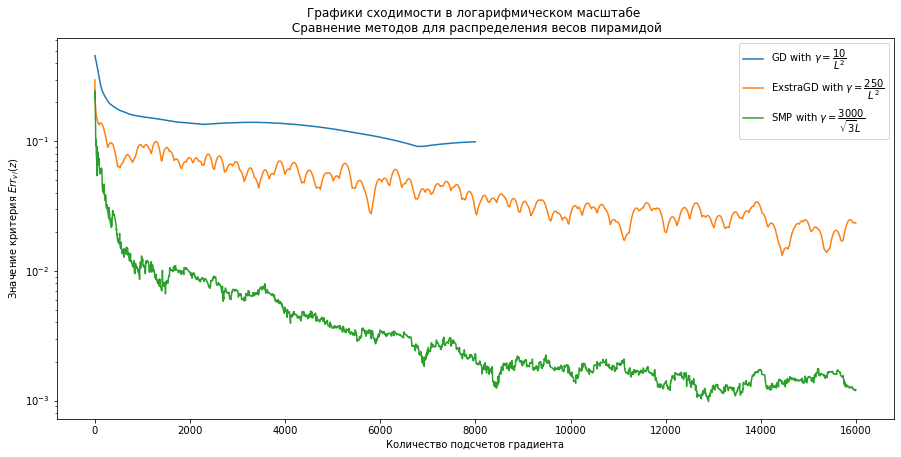

In [27]:
fig = plt.figure(figsize = (15, 7))

iter_grad_calls = 2
_, error = BilinearGD_simplex(nabla_f_x, nabla_f_y, proj_simplex, gamma_bilinear, 5, max_iter = 4 * 10**3)
x = np.array(range(len(error))) * iter_grad_calls
plt.plot(x, error, label = 'GD' + r' with $\gamma = \dfrac{10}{L^2}$')

iter_grad_calls = 4
_, error = ExtraGD_simplex(nabla_f_x, nabla_f_y, proj_simplex, gamma_bilinear, 250, max_iter = 4 * 10**3)
x = np.array(range(len(error))) * iter_grad_calls 
plt.plot(x, error, label = 'ExstraGD' + r' with $\gamma = \dfrac{250}{L^2}$')

_, error = SMP(nabla_f_x, nabla_f_y, prox_simplex, gamma_SMP, 2000, max_iter = 4 * 10**3, eps = 10**(-8))
x = np.array(range(len(error))) * iter_grad_calls
plt.plot(x, error, label = 'SMP' + r' with $\gamma = \dfrac{3000}{\sqrt{3}L}$')

plt.title("Графики сходимости в логарифмическом масштабе \n Сравнение методов для распределения весов пирамидой")
plt.xlabel("Количество подсчетов градиента")
plt.ylabel(r"Значение критерия $Err_{vi}(z)$")
plt.yscale("log")
plt.legend()
plt.show()

Теперь со случайными весами.

100%|██████████████████████████████████████| 4000/4000 [00:16<00:00, 243.04it/s]


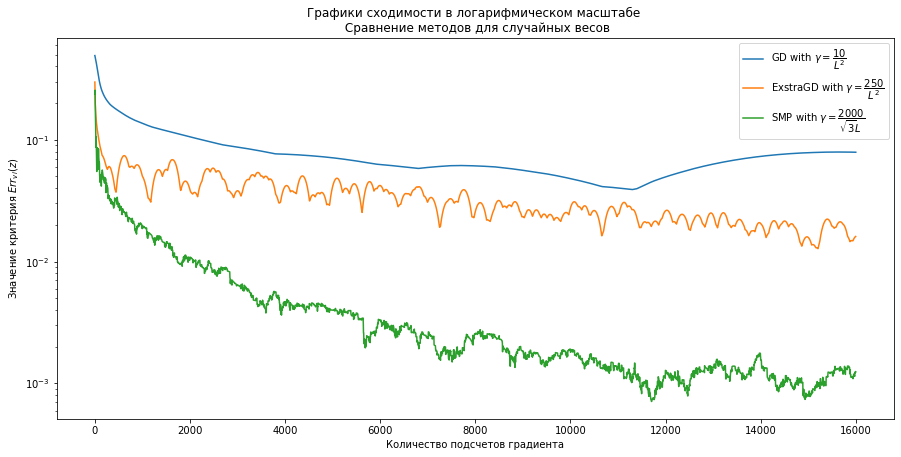

In [28]:
A = generate_houses(d, theta, dist_func)
L = 2 * max(np.linalg.eigvals(A).real)
fig = plt.figure(figsize = (15, 7))

iter_grad_calls = 2
_, error = BilinearGD_simplex(nabla_f_x, nabla_f_y, proj_simplex, gamma_bilinear, 5, max_iter = 8 * 10**3)
x = np.array(range(len(error))) * iter_grad_calls
plt.plot(x, error, label = 'GD' + r' with $\gamma = \dfrac{10}{L^2}$')

iter_grad_calls = 4
_, error = ExtraGD_simplex(nabla_f_x, nabla_f_y, proj_simplex, gamma_bilinear, 250, max_iter = 4 * 10**3)
x = np.array(range(len(error))) * iter_grad_calls 
plt.plot(x, error, label = 'ExstraGD' + r' with $\gamma = \dfrac{250}{L^2}$')

answer, error = SMP(nabla_f_x, nabla_f_y, prox_simplex, gamma_SMP, 2000, max_iter = 4 * 10**3, eps = 10**(-8))
x = np.array(range(len(error))) * iter_grad_calls
plt.plot(x, error, label = 'SMP' + r' with $\gamma = \dfrac{2000}{\sqrt{3}L}$')

plt.title("Графики сходимости в логарифмическом масштабе \n Сравнение методов для случайных весов")
plt.xlabel("Количество подсчетов градиента")
plt.ylabel(r"Значение критерия $Err_{vi}(z)$")
plt.yscale("log")
plt.legend()
plt.show()

Как видно, SMP показывает себя лучше всех, хотя и требует значительно больше времени(отдельно я его не выводил, но это видно на прогрессбаре).

Построим 3D графики:

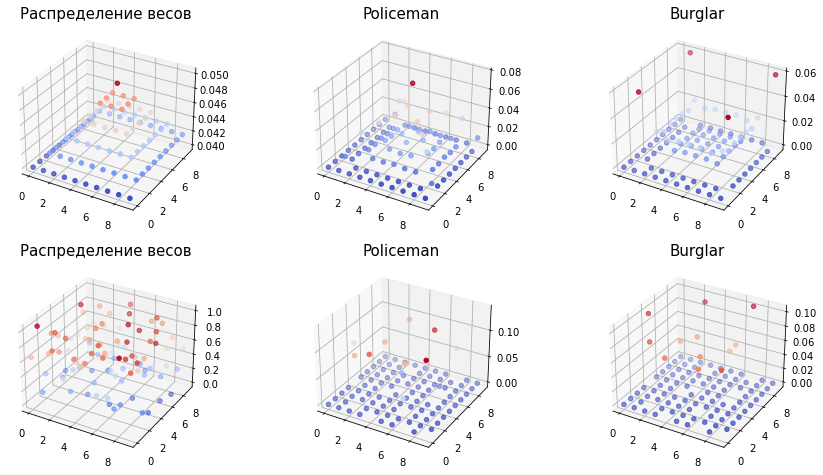

In [30]:
X, Y = np.meshgrid(range(n), range(n))
X = X.ravel()
Y = Y.ravel()
policeman, thief = np.split(answer, 2)
police, burglar = np.split(ans, 2)
w_pyramid = np.array([1 / (dist_func(i, (n // 2) * (n + 1), norm = np.inf) + 20) for i in range(100)])

fig, ax = plt.subplots(2, 3, subplot_kw = {"projection": "3d"}, figsize = (15, 8))

ax[0][0].scatter(X, Y, w_pyramid, c = w_pyramid, cmap = cm.coolwarm)
ax[0][0].set_title(f"Распределение весов", fontsize = 15, fontweight = 'light')
ax[0][1].scatter(X, Y, police, c = police,  cmap = cm.coolwarm)
ax[0][1].set_title(f"Policeman", fontsize = 15, fontweight = 'light')
ax[0][2].scatter(X, Y, burglar, c = burglar, cmap = cm.coolwarm)
ax[0][2].set_title(f"Burglar", fontsize = 15, fontweight = 'light')

ax[1][0].scatter(X, Y, w, c = w, cmap = cm.coolwarm)
ax[1][0].set_title(f"Распределение весов", fontsize = 15, fontweight = 'light')
ax[1][1].scatter(X, Y, policeman, c = policeman,  cmap = cm.coolwarm)
ax[1][1].set_title(f"Policeman", fontsize = 15, fontweight = 'light')
ax[1][2].scatter(X, Y, thief, c = thief, cmap = cm.coolwarm)
ax[1][2].set_title(f"Burglar", fontsize = 15, fontweight = 'light')

plt.show()

Как видно, для весов из презентации все получилось очень логично: полицеский в центре, вор в краях. А вот для случайных весов результат немного неочевидный: некоторые дома с большой вероятностью(отмечены более яркими точками) почти одинаковые для обоих.

__Бонусные пункты__

__(г)__ Реализуйте методы из Секции 3 [работы](https://arxiv.org/pdf/1908.08465.pdf). Решите с помощью них Задачу 1. Добавьте сходимость на график из пункта (б) Задачи 1.

In [ ]:
#ответ

__(д)__ Реализуйте Алгоритм 1 и Алгоритм 2 из [работы](https://arxiv.org/pdf/2102.08352.pdf). Решите с помощью них Задачу 2 (могут помочь Секции 5 и 6 из упомянутой работы). Добавьте сходимость на график из пункта (в) Задачи 2, предварительно поменяв ось $x$ (что теперь будете откладывать по оси $x$?).

In [ ]:
#ответ